## Hyper Parameter Tuning

#### 목차
1. 데이터 불러오기
2. 주차별 전체상품 판매수량과 변수들간 상관관계 파악
3. 주가 lag (3일전) 컬럼 추가
4. 가중치 적용
5. 중요도에 따른 변수 선정 과정
6. 하이퍼파라미터 조정 (pycaret)
7. 상위 5개 모델 확인
    - 7-1. 모델별 결과 확인
    - 7-2. Item별 rmse 확인
8. Stepwise Feature Selection (단계별 변수 선택법)

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import platform
from pycaret.regression import *

from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumSquare')

### 1) 데이터 불러오기

In [ ]:
data = pd.read_pickle('./data/train_외부변수포함_final(0901).pkl')

In [ ]:
train_new = data.copy()
train_new['일'] = train_new['date_w'].dt.day
train_new['주기성_변수'] = np.sin(2 * np.pi * train_new['월'] / 12)
train_new['월_일_년도'] = train_new['월'] * 10000 + train_new['일'] * 100 + train_new['년도']
train_new = pd.get_dummies(train_new, columns=['옵션코드'])

### 2) 주차별 전체상품 판매수량과 변수들간 상관관계 파악

In [ ]:
train_new.corr().sort_values('판매수량', ascending = False)

,상품 바코드,판매수량,공휴일,공휴일_여부,최고기온(°C),patient,년도,분기,월,주,...,월별_PRICE,주별_QUANTITY,주별_AMOUNT,주별_PRICE,일,주기성_변수,월_일_년도,옵션코드_BX,옵션코드_CS,옵션코드_EA
판매수량,-1.471176e-01,1.000000,-0.043601,-0.105724,0.364914,-0.005352,-7.321027e-02,-0.075384,-0.098426,-0.092834,...,0.157775,0.179299,0.060083,0.113275,-4.340625e-04,-0.075291,-0.104383,-5.476107e-01,5.319604e-01,8.166169e-02
옵션코드_CS,-2.556121e-01,0.531960,-0.114321,-0.178666,0.286317,0.012803,-7.146210e-02,-0.073077,-0.110121,-0.115345,...,0.186347,-0.103351,0.039278,0.106008,1.101558e-17,-0.088910,-0.116250,-8.017837e-01,1.000000e+00,-2.182179e-01
최고기온(°C),3.580905e-01,0.364914,-0.252612,-0.338620,1.000000,-0.264699,-8.007112e-01,0.584855,0.544805,0.527746,...,0.422662,0.527605,0.326976,0.376896,9.220498e-03,0.633139,0.520803,8.433883e-02,2.863168e-01,-5.750808e-01
경북경제활동,1.806680e-01,0.363985,-0.149443,-0.149137,0.471865,-0.064791,-9.364459e-02,0.001678,0.015643,0.010982,...,0.728540,0.441705,0.566348,0.659901,3.126989e-05,0.043878,0.011567,-6.078315e-01,6.421841e-01,1.163239e-02
stock_gaya_max,1.449067e-01,0.346021,-0.251520,-0.340633,0.842706,-0.306660,-8.340096e-01,0.414118,0.339515,0.325519,...,0.397857,0.537438,0.404345,0.403051,2.339500e-06,0.423879,0.308132,9.855221e-02,3.675531e-01,-7.223818e-01
stock_gaya_mean,1.722944e-01,0.309246,-0.258623,-0.348640,0.851678,-0.312173,-8.577229e-01,0.441462,0.367231,0.351389,...,0.393171,0.534335,0.395911,0.398526,2.974204e-06,0.453048,0.335403,1.298979e-01,3.449252e-01,-7.390044e-01
stock_gaya_min,2.263298e-01,0.291417,-0.269601,-0.359525,0.871875,-0.315108,-8.767613e-01,0.473202,0.402477,0.384087,...,0.407502,0.523749,0.384063,0.403883,-2.692001e-06,0.488111,0.370612,1.261602e-01,3.484166e-01,-7.382338e-01
분기별_QUANTITY,1.208711e-01,0.285723,-0.205480,-0.250908,0.577905,-0.182452,-3.267363e-01,-0.059620,-0.076997,-0.080409,...,0.764278,0.771376,0.778927,0.837913,8.801343e-04,-0.020883,-0.094411,-1.419034e-01,2.585432e-01,-1.632040e-01
stock_samda_min,2.487105e-01,0.246253,-0.251901,-0.371872,0.771289,-0.284167,-8.876674e-01,0.373702,0.298951,0.273402,...,0.316408,0.384218,0.297121,0.343906,3.240503e-03,0.375359,0.264261,2.023344e-01,3.047333e-01,-7.958984e-01
stock_samda_max,2.626361e-01,0.242376,-0.246320,-0.364147,0.769787,-0.285065,-9.034756e-01,0.395355,0.319761,0.294223,...,0.277819,0.365958,0.261413,0.304103,3.487309e-03,0.394551,0.284850,2.393994e-01,2.704845e-01,-8.041095e-01


### 3) 주가 lag (3일전) 컬럼 추가
- 모든 item에 대해 3개의 품목 (삼다수, 가야산, 코카콜라)의 3일치 주가 데이터를 변수로 추가
- 기존에 사용했던 주가 컬럼은 제외하고 학습
    - 'stock_gaya_min', 'stock_gaya_max', 'stock_gaya_mean', 'stock_coke_min',
       'stock_coke_max', 'stock_coke_mean', 'stock_samda_min',
       'stock_samda_max', 'stock_samda_mean'

In [ ]:
coke_all = pd.read_pickle('./data/콜라전체기간주가.pkl')
samda_all = pd.read_pickle('./data/삼다수전체기간주가.pkl')
gaya_all = pd.read_pickle('./data/가야전체기간주가.pkl')

In [ ]:
cola_base = pd.DataFrame()
for item in data['상품 바코드'].unique().tolist():
      item_df = pd.DataFrame()
      item_df['date_w'] = coke_all['date_w']
      item_df['종가'] = coke_all['종가']
      item_df['상품 바코드'] = item
      cola_base = pd.concat([cola_base, item_df], axis=0)

samda_base = pd.DataFrame()
for item in data['상품 바코드'].unique().tolist():
      item_df = pd.DataFrame()
      item_df['date_w'] = coke_all['date_w']
      item_df['종가'] = coke_all['종가']
      item_df['상품 바코드'] = item
      samda_base = pd.concat([samda_base, item_df], axis=0)

gaya_base = pd.DataFrame()
for item in data['상품 바코드'].unique().tolist():
      item_df = pd.DataFrame()
      item_df['date_w'] = coke_all['date_w']
      item_df['종가'] = coke_all['종가']
      item_df['상품 바코드'] = item
      gaya_base = pd.concat([gaya_base, item_df], axis=0)

In [ ]:
df = pd.merge(train_new, cola_base, how='right',on=['상품 바코드', 'date_w'])

In [ ]:
def create_var(df, name):
    item_list = df['상품 바코드'].value_counts().index

    # 기본 데이터프레임 만들어놓기
    base = pd.DataFrame()

    for i in item_list:
        df1 = df[df['상품 바코드'] == i]
        df1.index = df1['date_w']

        df1[f"{name}_종가_lag3"] = df1['종가'].shift(3)
        df1[f"{name}_종가_lag3"].fillna(method='bfill', inplace=True)

        df1[f"{name}_종가_lag2"] = df1['종가'].shift(2)
        df1[f"{name}_종가_lag2"].fillna(method='bfill', inplace=True)

        df1[f"{name}_종가_lag1"] = df1['종가'].shift(1)
        df1[f"{name}_종가_lag1"].fillna(method='bfill', inplace=True)

        base = pd.concat([base, df1], axis=0)
    return base

In [ ]:
data_coke = create_var(cola_base, "coke")
data_coke = data_coke.reset_index(drop=True)
data_coke.rename(columns={'종가':'coke_종가'}, inplace = True)
data_coke

,date_w,coke_종가,상품 바코드,coke_종가_lag3,coke_종가_lag2,coke_종가_lag1
0,2020-09-28,49.2700,8.801043e+12,49.2700,49.2700,49.2700
1,2020-10-05,49.8300,8.801043e+12,49.2700,49.2700,49.2700
2,2020-10-12,50.2900,8.801043e+12,49.2700,49.2700,49.8300
3,2020-10-19,50.2120,8.801043e+12,49.2700,49.8300,50.2900
4,2020-10-26,48.7480,8.801043e+12,49.8300,50.2900,50.2120
...,...,...,...,...,...,...
1265,2023-01-30,60.6800,6.880106e+13,61.8780,60.3225,60.6020
1266,2023-02-06,59.8400,6.880106e+13,60.3225,60.6020,60.6800
1267,2023-02-13,59.8240,6.880106e+13,60.6020,60.6800,59.8400
1268,2023-02-20,59.9275,6.880106e+13,60.6800,59.8400,59.8240


In [ ]:
df = pd.merge(train_new, data_coke, how='left',on=['상품 바코드', 'date_w'])
df

,date_w,상품 바코드,상품명,판매수량,공휴일,공휴일_여부,최고기온(°C),patient,년도,분기,...,일,주기성_변수,월_일_년도,옵션코드_BX,옵션코드_CS,옵션코드_EA,coke_종가,coke_종가_lag3,coke_종가_lag2,coke_종가_lag1
0,2021-01-04,8.801043e+12,농심]안성탕면 멀티<40>,48.0,0.000000,0.000000,0.271830,-1.520142,30.188764,0.086273,...,4,0.035994,1117.781518,1,0,0,51.3000,53.4360,53.0225,54.3925
1,2021-01-11,8.801043e+12,농심]안성탕면 멀티<40>,51.0,0.000000,0.000000,1.418818,-0.922054,30.188764,0.086273,...,11,0.035994,1817.781518,1,0,0,49.6800,53.0225,54.3925,51.3000
2,2021-01-18,8.801043e+12,농심]안성탕면 멀티<40>,71.0,0.000000,0.000000,1.573518,-0.689463,30.188764,0.086273,...,18,0.035994,2517.781518,1,0,0,48.6575,54.3925,51.3000,49.6800
3,2021-01-25,8.801043e+12,농심]안성탕면 멀티<40>,54.0,0.000000,0.000000,1.480698,-1.312473,30.188764,0.086273,...,25,0.035994,3217.781518,1,0,0,48.7800,51.3000,49.6800,48.6575
4,2021-02-01,8.801043e+12,농심]안성탕면 멀티<40>,72.0,0.000000,0.000000,1.692857,-0.398726,30.188764,0.086273,...,1,0.071942,1505.374273,1,0,0,48.9740,49.6800,48.6575,48.7800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2022-05-30,6.880106e+13,레쓰비<175ml*30>,56.0,-0.118364,-0.063267,10.372962,-105.035492,-569.650247,0.587661,...,30,0.765120,19069.564626,1,0,0,63.2875,64.6320,62.7840,63.9860
776,2022-06-06,6.880106e+13,레쓰비<175ml*30>,77.0,-0.118364,-0.063267,9.245075,-79.689257,-569.650247,0.587661,...,6,0.865162,19997.407601,1,0,0,62.4440,62.7840,63.9860,63.2875
777,2022-06-13,6.880106e+13,레쓰비<175ml*30>,110.0,-0.000000,-0.000000,11.068893,-58.408800,-569.650247,0.587661,...,13,0.865162,20697.407601,1,0,0,59.7480,63.9860,63.2875,62.4440
778,2022-06-20,6.880106e+13,레쓰비<175ml*30>,120.0,-0.000000,-0.000000,13.156684,-44.515948,-569.650247,0.587661,...,20,0.865162,21397.407601,1,0,0,61.6925,63.2875,62.4440,59.7480


In [ ]:
data_samda = create_var(samda_base, "samda")
data_samda = data_samda.reset_index(drop=True)
data_gaya = create_var(gaya_base, "gaya")
data_gaya = data_gaya.reset_index(drop=True)

In [ ]:
data_samda.rename(columns={'종가':'samda_종가'}, inplace = True)
data_gaya.rename(columns={'종가':'gaya_종가'}, inplace = True)

df = pd.merge(df, data_samda, how='left',on=['상품 바코드', 'date_w'])
df = pd.merge(df, data_gaya, how='left',on=['상품 바코드', 'date_w'])

In [ ]:
df.sort_values('date_w')

,date_w,상품 바코드,상품명,판매수량,공휴일,공휴일_여부,최고기온(°C),patient,년도,분기,...,coke_종가_lag2,coke_종가_lag1,samda_종가,samda_종가_lag3,samda_종가_lag2,samda_종가_lag1,gaya_종가,gaya_종가_lag3,gaya_종가_lag2,gaya_종가_lag1
0,2021-01-04,8.801043e+12,농심]안성탕면 멀티<40>,48.0,0.0,0.0,0.271830,-1.520142,30.188764,0.086273,...,53.0225,54.3925,51.300,53.436,53.0225,54.3925,51.300,53.436,53.0225,54.3925
546,2021-01-04,8.809274e+12,가야산천년수<2L*6>,812.0,-0.0,-0.0,0.969500,-6.246555,-493.166987,0.155245,...,53.0225,54.3925,51.300,53.436,53.0225,54.3925,51.300,53.436,53.0225,54.3925
702,2021-01-04,6.880106e+13,레쓰비<175ml*30>,37.0,-0.0,-0.0,0.737926,-3.166117,-569.368521,0.293830,...,53.0225,54.3925,51.300,53.436,53.0225,54.3925,51.300,53.436,53.0225,54.3925
78,2021-01-04,8.801043e+12,농심]신라면 멀티<40>,45.0,0.0,0.0,-0.013918,0.539659,48.455162,0.325617,...,53.0225,54.3925,51.300,53.436,53.0225,54.3925,51.300,53.436,53.0225,54.3925
234,2021-01-04,8.801043e+12,농심]짜파게티 멀티<40>,25.0,-0.0,-0.0,0.117280,-2.854455,-268.742716,0.224395,...,53.0225,54.3925,51.300,53.436,53.0225,54.3925,51.300,53.436,53.0225,54.3925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2022-06-27,8.801043e+12,농심]너구리 얼큰멀티<40>,15.0,-0.0,-0.0,0.702273,-6.626527,-131.230175,0.092441,...,59.7480,61.6925,63.042,62.444,59.7480,61.6925,63.042,62.444,59.7480,61.6925
155,2022-06-27,8.801043e+12,농심]신라면 멀티<40>,52.0,0.0,0.0,-0.254149,10.627557,48.479137,0.651235,...,59.7480,61.6925,63.042,62.444,59.7480,61.6925,63.042,62.444,59.7480,61.6925
77,2022-06-27,8.801043e+12,농심]안성탕면 멀티<40>,63.0,0.0,0.0,4.963652,-29.936283,30.203701,0.172546,...,59.7480,61.6925,63.042,62.444,59.7480,61.6925,63.042,62.444,59.7480,61.6925
701,2022-06-27,1.880105e+13,오뚜기]진라면매운멀티<120g>,31.0,-0.0,-0.0,6.297609,-99.029218,-171.920022,0.095778,...,59.7480,61.6925,63.042,62.444,59.7480,61.6925,63.042,62.444,59.7480,61.6925


In [ ]:
df = df.drop(['stock_gaya_min', 'stock_gaya_max', 'stock_gaya_mean', 'stock_coke_min',
       'stock_coke_max', 'stock_coke_mean', 'stock_samda_min',
       'stock_samda_max', 'stock_samda_mean'], axis=1)

### 4) 가중치 적용
- 각각의 상관계수 값을 가중치로 적용

In [ ]:
# 가중치 df - 일, 주기성 변수
weight_df = df[df[['상품 바코드', '상품명']].duplicated() == False][['상품 바코드', '상품명']].reset_index(drop=True)

In [ ]:
cycle = []
date=[]

coke = []
coke1 = []
coke2 = []
coke3 = []

samda = []
samda1 = []
samda2 = []
samda3 = []

gaya = []
gaya1 = []
gaya2 = []
gaya3 = []

for i in range(len(weight_df)):
    item_df = df[df['상품 바코드'] == weight_df.loc[i, '상품 바코드']]
    item_corr = item_df.corr()['판매수량']

    cycle.append(item_corr['주기성_변수'])
    date.append(item_corr['월_일_년도'])

    coke.append(item_corr['coke_종가'])
    coke1.append(item_corr['coke_종가_lag1'])
    coke2.append(item_corr['coke_종가_lag2'])
    coke3.append(item_corr['coke_종가_lag3'])

    samda.append(item_corr['samda_종가'])
    samda1.append(item_corr['samda_종가_lag1'])
    samda2.append(item_corr['samda_종가_lag2'])
    samda3.append(item_corr['samda_종가_lag3'])

    gaya.append(item_corr['gaya_종가'])
    gaya1.append(item_corr['gaya_종가_lag1'])
    gaya2.append(item_corr['gaya_종가_lag2'])
    gaya3.append(item_corr['gaya_종가_lag3'])


In [ ]:
weight_df['주기성_변수_가중치'] = cycle
weight_df['월_일_년도_가중치'] = date

weight_df['coke_종가_가중치'] = coke
weight_df['coke_종가_lag1_가중치'] = coke1
weight_df['coke_종가_lag2_가중치'] = coke2
weight_df['coke_종가_lag3_가중치'] = coke3

weight_df['samda_종가_가중치'] = samda
weight_df['samda_종가_lag1_가중치'] = samda1
weight_df['samda_종가_lag2_가중치'] = samda2
weight_df['samda_종가_lag3_가중치'] = samda3

weight_df['gaya_종가_가중치'] = gaya
weight_df['gaya_종가_lag1_가중치'] = gaya1
weight_df['gaya_종가_lag2_가중치'] = gaya2
weight_df['gaya_종가_lag3_가중치'] = gaya3


In [ ]:
train_new = pd.merge(df, weight_df, how='left', on=['상품 바코드', '상품명'])
train_new['주기성_변수'] = train_new['주기성_변수'] * train_new['주기성_변수_가중치']
train_new['월_일_년도'] =  train_new['월_일_년도'] * train_new['월_일_년도_가중치']

train_new['coke_종가'] = train_new['coke_종가'] * train_new['coke_종가_가중치']
train_new['coke_종가_lag1'] = train_new['coke_종가_lag1'] * train_new['coke_종가_lag1_가중치']
train_new['coke_종가_lag2'] = train_new['coke_종가_lag2'] * train_new['coke_종가_lag2_가중치']
train_new['coke_종가_lag3'] = train_new['coke_종가_lag3'] * train_new['coke_종가_lag3_가중치']


train_new['samda_종가'] = train_new['samda_종가'] * train_new['samda_종가_가중치']
train_new['samda_종가_lag1'] = train_new['samda_종가_lag1'] * train_new['samda_종가_lag1_가중치']
train_new['samda_종가_lag2'] = train_new['samda_종가_lag2'] * train_new['samda_종가_lag2_가중치']
train_new['samda_종가_lag3'] = train_new['samda_종가_lag3'] * train_new['samda_종가_lag3_가중치']

train_new['gaya_종가'] = train_new['gaya_종가'] * train_new['gaya_종가_가중치']
train_new['gaya_종가_lag1'] = train_new['gaya_종가_lag1'] * train_new['gaya_종가_lag1_가중치']
train_new['gaya_종가_lag2'] = train_new['gaya_종가_lag2'] * train_new['gaya_종가_lag2_가중치']
train_new['gaya_종가_lag3'] = train_new['gaya_종가_lag3'] * train_new['gaya_종가_lag3_가중치']

train_new.drop(['주기성_변수_가중치','월_일_년도_가중치','일'], axis=1, inplace=True)
train_new.drop(['coke_종가_가중치',
       'coke_종가_lag1_가중치', 'coke_종가_lag2_가중치', 'coke_종가_lag3_가중치',
       'samda_종가_가중치', 'samda_종가_lag1_가중치', 'samda_종가_lag2_가중치',
       'samda_종가_lag3_가중치', 'gaya_종가_가중치', 'gaya_종가_lag1_가중치',
       'gaya_종가_lag2_가중치', 'gaya_종가_lag3_가중치'], axis=1, inplace=True)

In [ ]:
train_new

,date_w,상품 바코드,상품명,판매수량,공휴일,공휴일_여부,최고기온(°C),patient,년도,분기,...,coke_종가_lag2,coke_종가_lag1,samda_종가,samda_종가_lag3,samda_종가_lag2,samda_종가_lag1,gaya_종가,gaya_종가_lag3,gaya_종가_lag2,gaya_종가_lag1
0,2021-01-04,8.801043e+12,농심]안성탕면 멀티<40>,48.0,0.000000,0.000000,0.271830,-1.520142,30.188764,0.086273,...,4.049554,4.511376,4.833259,4.222584,4.049554,4.511376,4.833259,4.222584,4.049554,4.511376
1,2021-01-11,8.801043e+12,농심]안성탕면 멀티<40>,51.0,0.000000,0.000000,1.418818,-0.922054,30.188764,0.086273,...,4.154186,4.254880,4.680630,4.189909,4.154186,4.254880,4.680630,4.189909,4.154186,4.254880
2,2021-01-18,8.801043e+12,농심]안성탕면 멀티<40>,71.0,0.000000,0.000000,1.573518,-0.689463,30.188764,0.086273,...,3.917999,4.120516,4.584294,4.298168,3.917999,4.120516,4.584294,4.298168,3.917999,4.120516
3,2021-01-25,8.801043e+12,농심]안성탕면 멀티<40>,54.0,0.000000,0.000000,1.480698,-1.312473,30.188764,0.086273,...,3.794273,4.035708,4.595836,4.053795,3.794273,4.035708,4.595836,4.053795,3.794273,4.035708
4,2021-02-01,8.801043e+12,농심]안성탕면 멀티<40>,72.0,0.000000,0.000000,1.692857,-0.398726,30.188764,0.086273,...,3.716180,4.045869,4.614113,3.925780,3.716180,4.045869,4.614113,3.925780,3.716180,4.045869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2022-05-30,6.880106e+13,레쓰비<175ml*30>,56.0,-0.118364,-0.063267,10.372962,-105.035492,-569.650247,0.587661,...,-9.702715,-9.639452,-9.866345,-9.450365,-9.702715,-9.639452,-9.866345,-9.450365,-9.702715,-9.639452
776,2022-06-06,6.880106e+13,레쓰비<175ml*30>,77.0,-0.118364,-0.063267,9.245075,-79.689257,-569.650247,0.587661,...,-9.888473,-9.534224,-9.734846,-9.180154,-9.888473,-9.534224,-9.734846,-9.180154,-9.888473,-9.534224
777,2022-06-13,6.880106e+13,레쓰비<175ml*30>,110.0,-0.000000,-0.000000,11.068893,-58.408800,-569.650247,0.587661,...,-9.780526,-9.407151,-9.314547,-9.355908,-9.780526,-9.407151,-9.314547,-9.355908,-9.780526,-9.407151
778,2022-06-20,6.880106e+13,레쓰비<175ml*30>,120.0,-0.000000,-0.000000,13.156684,-44.515948,-569.650247,0.587661,...,-9.650171,-9.001000,-9.617689,-9.253775,-9.650171,-9.001000,-9.617689,-9.253775,-9.650171,-9.001000


### 5) 중요도에 따른 변수 선정 과정

In [ ]:
# 날짜 기준으로 train/valid 분리
from sklearn.model_selection import train_test_split
series2 = train_new
train = series2[series2['date_w'] < '2022-03-10']
val = series2[series2['date_w'] >= '2022-03-10']
print('train 데이터:', train.shape)
print('val 데이터:', val.shape)

train 데이터: (620, 57)
val 데이터: (160, 57)


In [ ]:
y_train = train[['판매수량','상품 바코드','date_w', '상품명']]
x_train = train.drop(['판매수량', 'date_w', '상품명','상품 바코드'], axis=1)

y_val = val[['판매수량','상품 바코드','date_w', '상품명']]
x_val = val.drop(['판매수량','상품 바코드','date_w', '상품명'], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
#train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
#val[columns_to_scale] = scaler.transform(val[columns_to_scale])
columns_to_scale = x_train.columns

x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_val[columns_to_scale] = scaler.transform(x_val[columns_to_scale])

### 6) 하이퍼파라미터 조정 (pycaret)
- 참고 블로그 : https://dsbook.tistory.com/360

In [ ]:
Train =  pd.concat([x_train, y_train], axis =1)
Test = pd.concat([x_val, y_val], axis=1)

In [ ]:
Train

,공휴일,공휴일_여부,최고기온(°C),patient,년도,분기,월,주,소비자심리지수,경제심리지수(원계열),...,samda_종가_lag2,samda_종가_lag1,gaya_종가,gaya_종가_lag3,gaya_종가_lag2,gaya_종가_lag1,판매수량,상품 바코드,date_w,상품명
0,0.815601,0.665085,0.416200,0.471811,0.307897,0.406613,0.365987,0.342936,0.558925,0.530920,...,0.297435,0.290435,0.294097,0.311638,0.297435,0.290435,48.0,8.801043e+12,2021-01-04,농심]안성탕면 멀티<40>
1,0.815601,0.665085,0.454287,0.471919,0.307897,0.406613,0.365987,0.345531,0.558925,0.530920,...,0.299723,0.285076,0.291012,0.310867,0.299723,0.285076,51.0,8.801043e+12,2021-01-11,농심]안성탕면 멀티<40>
2,0.815601,0.665085,0.459424,0.471961,0.307897,0.406613,0.365987,0.348125,0.558925,0.530920,...,0.294558,0.282269,0.289065,0.313422,0.294558,0.282269,71.0,8.801043e+12,2021-01-18,농심]안성탕면 멀티<40>
3,0.815601,0.665085,0.456342,0.471849,0.307897,0.406613,0.365987,0.350719,0.558925,0.530920,...,0.291852,0.280497,0.289298,0.307654,0.291852,0.280497,54.0,8.801043e+12,2021-01-25,농심]안성탕면 멀티<40>
4,0.815601,0.665085,0.463387,0.472013,0.307897,0.406613,0.377095,0.353314,0.559809,0.535148,...,0.290144,0.280710,0.289668,0.304633,0.290144,0.280710,72.0,8.801043e+12,2021-02-01,농심]안성탕면 멀티<40>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,0.815601,0.665085,0.545429,0.432145,0.000000,0.507881,0.462399,0.411440,0.749541,0.701716,...,0.006196,0.004003,0.003384,0.002260,0.006196,0.004003,106.0,6.880106e+13,2022-02-07,레쓰비<175ml*30>
760,0.815601,0.665085,0.486262,0.412054,0.000000,0.507881,0.462399,0.423290,0.749541,0.701716,...,0.002513,0.003380,0.002855,0.005024,0.002513,0.003380,91.0,6.880106e+13,2022-02-14,레쓰비<175ml*30>
761,0.815601,0.665085,0.537262,0.370326,0.000000,0.507881,0.462399,0.435139,0.749541,0.701716,...,0.001844,0.002851,0.001665,0.001263,0.001844,0.002851,40.0,6.880106e+13,2022-02-21,레쓰비<175ml*30>
762,0.684727,0.445405,0.600413,0.322805,0.000000,0.507881,0.462399,0.446989,0.749541,0.701716,...,0.001276,0.001663,0.000000,0.000580,0.001276,0.001663,97.0,6.880106e+13,2022-02-28,레쓰비<175ml*30>


In [ ]:
# !pip install pycaret[full]
# minmax 적용
ixi_model = setup(session_id =1, data = train,
                  target='판매수량', test_data = val, normalize = True, normalize_method='minmax',
                  transformation=True, fold_strategy='stratifiedkfold', use_gpu = True)

In [ ]:
models() #사용할 수 있는 모델 list

In [ ]:
# n_select = 설정한 수 만큼의 모델의 순위
# sort : 결과 출력시 정렬 기준
# include : 비교할 모델
pycaret_regression_models = compare_models(n_select = 25, sort='RMSE',
                            include = ['lr','lasso','ridge','en','lar',
                                      'llar', 'omp', 'br', 'ard', 'par',
                                      'ransac','tr','huber', 'kr', 'svm', 'knn',
                                      'dt', 'rf', 'et', 'ada', 'gbr', 'mlp',
                                      'xgboost', 'lightgbm', 'dummy'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,52.2790,12502.4686,109.1727,0.8855,0.5012,0.5437,0.7770
rf,Random Forest Regressor,52.5279,12962.5525,112.3277,0.8795,0.5017,0.5283,0.7340
knn,K Neighbors Regressor,55.2326,14010.5871,113.4315,0.8771,0.5139,0.5294,0.2360
br,Bayesian Ridge,66.5627,14539.3264,116.4467,0.8719,0.8098,0.9161,0.1810
ada,AdaBoost Regressor,68.5324,14305.5499,117.1214,0.8721,0.8042,1.3102,0.3170
lightgbm,Light Gradient Boosting Machine,56.7341,14743.9534,117.1651,0.8688,0.5803,0.5748,1.5610
ard,Automatic Relevance Determination,68.5724,14671.6207,117.2728,0.8704,0.8419,0.9850,0.5620
kr,Kernel Ridge,63.8442,14953.4920,117.4638,0.8703,0.7711,0.8309,0.1940
ridge,Ridge Regression,63.9770,14963.4368,117.5077,0.8702,0.7683,0.8304,0.1750
llar,Lasso Least Angle Regression,62.1455,15550.1883,119.4768,0.8657,0.6876,0.7341,0.1860


Processing:   0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
# 하이퍼 파라미터 튜닝 (gbr)
# RMSE : 109.1727 -> 102.9061
from sklearn.ensemble import GradientBoostingRegressor
from pycaret.regression import tune_model
from sklearn.linear_model import *

default_gbr_model = GradientBoostingRegressor()
tunned_gbr_model = tune_model(default_gbr_model, n_iter=100, optimize ="RMSE" )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53.1273,9770.9953,98.8483,0.9223,0.5317,0.5475
1,41.0523,7658.5513,87.5131,0.9369,0.3457,0.3194
2,63.4792,18394.5027,135.6263,0.8281,0.4507,0.3969
3,42.1867,6677.8845,81.7183,0.9406,0.4521,0.4609
4,41.9545,7115.6579,84.3544,0.9269,0.4807,0.4459
5,59.0948,14595.2494,120.8108,0.9056,0.5117,0.5600
6,39.6620,2957.2560,54.3807,0.9766,0.5536,0.6093
7,61.2112,12608.8886,112.2893,0.8371,0.5614,0.4657
8,48.2638,8596.1051,92.7152,0.9056,0.5815,1.0706


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
# save_model(tunned_gbr_model, './gbr') # 모델 저장

In [ ]:
# load_gbr = load_model('./gbr') # 모델 불러오기
# load_gbr['trained_model']

Transformation Pipeline and Model Successfully Loaded


GradientBoostingRegressor(max_depth=2, max_features=1.0,
                          min_impurity_decrease=0.01, min_samples_split=5,
                          n_estimators=180, subsample=0.75)

### 7) 상위 5개 모델 확인
- 2가지 방법 존재
- 상위 n개의 모델 앙상블
- 원하는 모델 학습시켜서 앙상블

In [ ]:
# 상위 5개 모델로 앙상블
best_5 = compare_models(sort = 'RMSE', n_select= 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,52.2790,12502.4686,109.1727,0.8855,0.5012,0.5437,0.3880
rf,Random Forest Regressor,52.5279,12962.5525,112.3277,0.8795,0.5017,0.5283,0.4160
knn,K Neighbors Regressor,55.2326,14010.5871,113.4315,0.8771,0.5139,0.5294,0.3990
br,Bayesian Ridge,66.5627,14539.3264,116.4467,0.8719,0.8098,0.9161,0.3230
ada,AdaBoost Regressor,68.5324,14305.5499,117.1214,0.8721,0.8042,1.3102,0.4130
lightgbm,Light Gradient Boosting Machine,56.7341,14743.9534,117.1651,0.8688,0.5803,0.5748,0.5380
ridge,Ridge Regression,63.9770,14963.4368,117.5077,0.8702,0.7683,0.8304,0.3270
llar,Lasso Least Angle Regression,62.1455,15550.1883,119.4768,0.8657,0.6876,0.7341,0.3110
lasso,Lasso Regression,62.3497,15546.8013,119.4896,0.8657,0.7035,0.7378,0.3240
omp,Orthogonal Matching Pursuit,68.6244,15714.9802,120.9898,0.8624,0.7439,0.8500,0.3130


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
top5 = [rank for rank in best_5]

tuned_top5 = [tune_model(i) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.7667,7250.8340,85.1518,0.9423,0.5549,0.5205
1,49.3973,9825.4382,99.1233,0.9191,0.6575,0.4499
2,70.6955,21407.8168,146.3141,0.7999,0.7169,0.5159
3,50.6483,7785.9135,88.2378,0.9308,0.5932,0.6470
4,43.3065,5314.0872,72.8978,0.9454,0.7398,0.5231
5,66.4533,24763.8163,157.3652,0.8399,0.5514,0.5581
6,55.7765,13671.0884,116.9234,0.8919,0.6249,0.6558
7,62.6256,12511.2924,111.8539,0.8383,0.6140,0.5116
8,54.9190,9417.3468,97.0430,0.8966,0.6710,1.2366


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.0104,10944.7835,104.6173,0.9129,0.5076,0.5432
1,53.9586,13271.3980,115.2016,0.8907,0.4328,0.4438
2,60.6144,21865.1949,147.8688,0.7956,0.4790,0.4647
3,54.6216,11294.1995,106.2742,0.8996,0.5351,0.5932
4,36.1750,3391.6396,58.2378,0.9652,0.5344,0.5707
5,72.6723,36819.5516,191.8842,0.7620,0.5751,0.6537
6,60.7010,20462.4578,143.0470,0.8382,0.5589,0.6121
7,54.4337,9323.9228,96.5605,0.8795,0.5774,0.5022
8,53.1219,9155.1501,95.6825,0.8995,0.6319,1.2048


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.0698,11352.3811,106.5476,0.9097,0.4843,0.4644
1,41.9372,8492.5134,92.1548,0.9301,0.3130,0.2916
2,63.4204,20193.5838,142.1041,0.8113,0.4486,0.3987
3,53.4489,12155.2449,110.2508,0.8919,0.4575,0.4450
4,41.8494,4559.1309,67.5213,0.9532,0.5057,0.4854
5,72.5009,34625.2100,186.0785,0.7761,0.5150,0.5318
6,56.7365,20454.8844,143.0206,0.8382,0.4749,0.4707
7,51.0410,8072.0481,89.8446,0.8957,0.5126,0.4139
8,47.6319,8245.8883,90.8069,0.9095,0.5619,0.8853


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61.6773,13048.2913,114.2291,0.8962,0.7809,0.6037
1,56.6233,11623.7261,107.8134,0.9043,0.6650,0.5386
2,69.3286,20811.1986,144.2609,0.8055,0.6978,0.5977
3,60.2108,11257.0982,106.0995,0.8999,0.7219,0.7001
4,51.9004,5024.0098,70.8802,0.9484,0.7669,0.8252
5,88.0029,35234.0237,187.7073,0.7722,0.7558,0.9153
6,68.6029,19744.2978,140.5144,0.8439,0.8339,0.8209
7,69.0757,10137.2716,100.6840,0.8690,1.1261,0.8480
8,65.9695,8788.7103,93.7481,0.9035,0.7547,1.9981


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61.4243,15983.4784,126.4258,0.8728,0.5863,0.6519
1,53.3093,10573.0096,102.8251,0.9129,0.4976,0.5491
2,63.6729,19712.8850,140.4026,0.8158,0.5256,0.5076
3,55.9233,12632.8874,112.3961,0.8876,0.5706,0.6680
4,44.1457,6124.9648,78.2622,0.9371,0.5505,0.5922
5,66.9346,21384.7572,146.2353,0.8617,0.5699,0.6632
6,52.7620,10119.1332,100.5939,0.9200,0.5546,0.6224
7,51.4445,7297.7887,85.4271,0.9057,0.5609,0.4616
8,49.9055,8129.4578,90.1635,0.9108,0.6164,1.1382


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
blended = blend_models(estimator_list = best_5,
                       fold = 10,
                      #method = 'soft',
                       optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53.4774,11513.9913,107.3033,0.9084,0.5130,0.5559
1,49.4716,9010.1226,94.9217,0.9258,0.4860,0.5457
2,60.8176,18615.2148,136.4376,0.8260,0.4564,0.4398
3,47.5682,9280.0635,96.3331,0.9175,0.5028,0.5555
4,41.4777,5249.3628,72.4525,0.9461,0.5236,0.5372
5,69.9433,27180.7482,164.8658,0.8243,0.5511,0.6183
6,53.6340,14096.7421,118.7297,0.8885,0.5180,0.5661
7,51.6125,7627.4620,87.3353,0.9014,0.5257,0.4609
8,48.4360,8280.1416,90.9953,0.9091,0.6252,1.2576


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 7-1) 모델별 결과 확인

In [ ]:
from pycaret.regression import create_model

gbr = create_model('gbr', cross_validation=False)
randomforest = create_model('rf', cross_validation=False)
knn = create_model('knn', cross_validation=False)
lightgbm = create_model('lightgbm', cross_validation=False)
# xgboost = create_model('xgboost', cross_validation=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,58.4016,18096.8206,134.5244,0.7996,0.4246,0.4361


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,55.0430,12403.6590,111.3717,0.8626,0.4314,0.4476


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,65.1400,14980.7812,122.3960,0.8341,0.5543,0.4223


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,47.1160,5985.9161,77.3687,0.9337,0.5464,0.4892


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_gbr = tune_model(gbr, optimize = 'RMSE', n_iter = 50)
tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 20)
tuned_knn = tune_model(knn, optimize = 'RMSE', n_iter = 20)
tuned_lightgbm = tune_model(lightgbm, optimize = 'RMSE', n_iter = 20)
# tuned_xgb = tune_model(xgb, optimize = 'RMSE', n_iter = 20)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:55:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [ ]:
blender_specific = blend_models(estimator_list = [tuned_gbr,tuned_rf,tuned_knn, tuned_lightgbm, tuned_xgb], optimize = 'RMSE')

In [ ]:
plot_model(blender_specific) #모델 시각화

In [ ]:
plot_model(blender_specific, plot='error')

In [ ]:
final_model = finalize_model(blender_specific

In [ ]:
pred = predict_model(final_model, data = test)

### 7-2) Item별 rmse 확인

In [ ]:
items = pd.read_pickle('./data/예측상품_10개.pkl')

In [ ]:
xg_rmse = []
rf_rmse = []
# lstm_rmse = []
total_rmse = []


for item in items['상품 바코드'].values:
    item_pred_val = pred_val[pred_val['상품 바코드'] == item]
    xg = np.sqrt(mean_squared_error(item_pred_val['판매수량'],item_pred_val['xg_pred']))
    xg_rmse.append(xg)
    rf = np.sqrt(mean_squared_error(item_pred_val['판매수량'], item_pred_val['rf_pred']))
    rf_rmse.append(rf)
#     lstm = np.sqrt(mean_squared_error(item_pred_val['판매수량'], item_pred_val['lstm_pred']))
#     lstm_rmse.append(lstm)


mse_list = {'xg':xg_rmse, 'rf':rf_rmse}
mse = pd.DataFrame(mse_list, index=items['상품명'].values)
mse = mse.append({'xg':np.mean(xg_rmse), 'rf':np.mean(rf_rmse)},ignore_index=True)
mse.index = ['가야산천년수<2L*6>', '삼다수2L', '박카스F 120ml', '레쓰비<175ml*30>',
             '코카콜라<1.5*12>','농심]안성탕면 멀티<40>', '농심]신라면 멀티<40>',
             '농심]짜파게티 멀티<40>', '오뚜기]진라면매운멀티<120g>',
             '농심]너구리 얼큰멀티<40>', '10개평균']
mse

,xg,rf
가야산천년수<2L*6>,301.743928,117.797088
삼다수2L,118.272556,109.178992
박카스F 120ml,24.441654,22.402738
레쓰비<175ml*30>,36.878607,34.808066
코카콜라<1.5*12>,118.617616,106.558288
농심]안성탕면 멀티<40>,45.722859,18.370699
농심]신라면 멀티<40>,14.022151,13.938147
농심]짜파게티 멀티<40>,11.212683,10.284332
오뚜기]진라면매운멀티<120g>,21.069419,22.310260
농심]너구리 얼큰멀티<40>,7.300814,5.962982


In [ ]:
def train_valid_graph(item, train_data, pred_train, pred_val):
    item_true = train_data[train_data['상품 바코드'] == item]
    #item_pred_train = pred_train[pred_train['상품 바코드(t)'] == item].sort_values(by='date_w(t)')
    item_pred = pred_val[pred_val['상품 바코드'] == item].sort_values(by='date_w')
    #item_pred = pd.concat([item_pred_train, item_pred_val], axis=0).sort_values(by='date_w(t)')

    plt.figure(figsize=(15,8))
    plt.title(item)
    plt.plot(item_true['date_w'], item_true['판매수량'])
    plt.plot(item_pred['date_w'], item_pred['xg_pred'], color='red')
    plt.plot(item_pred['date_w'], item_pred['rf_pred'], color='green')
#     plt.plot(item_pred['date_w'], item_pred['lstm_pred'], color='black')

#     plt.plot(item_pred['date_w(t)'], item_pred['mlp_pred'], color='purple')
    plt.show()

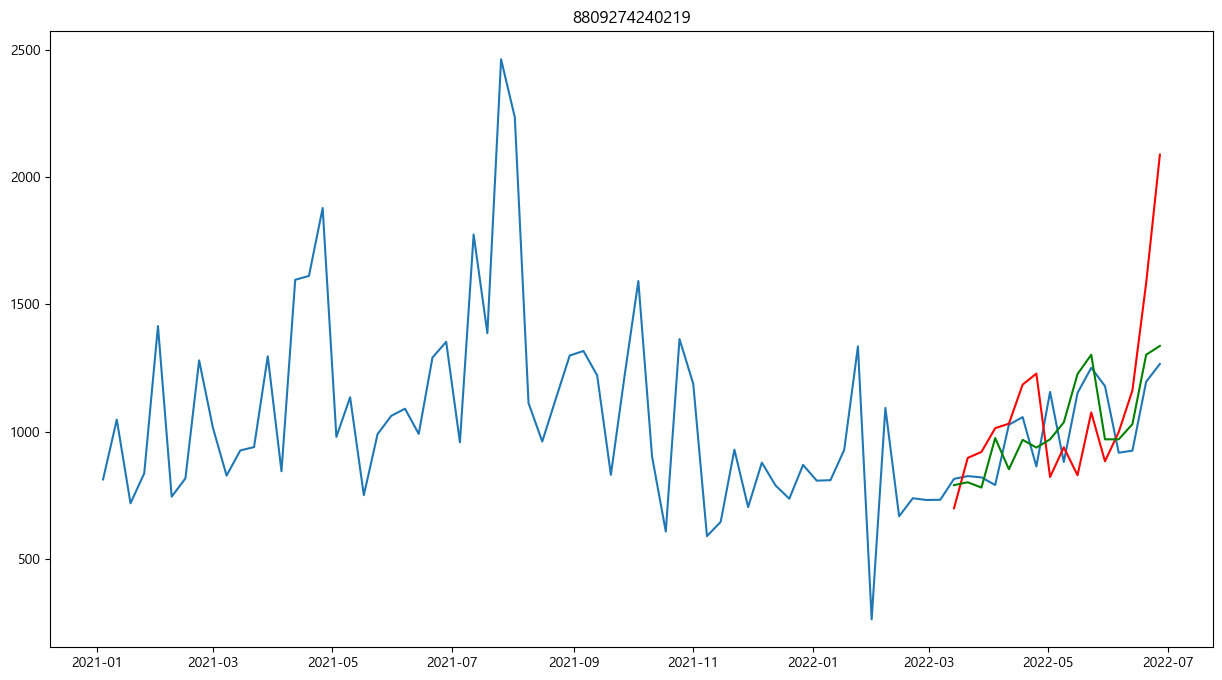

In [ ]:
train_valid_graph(items['상품 바코드'].values[0], train_new, pred_train, pred_val)

In [ ]:
merge_X = pd.concat([x_train, x_val], axis=0)

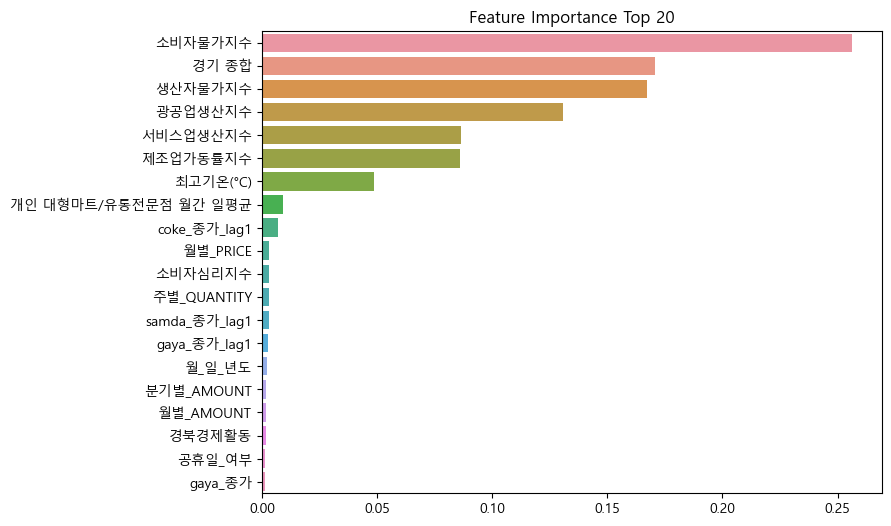

In [ ]:
# 배열형태로 반환
ft_importance_values = best_rf_model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
factor = train_new.corr()['판매수량']
factor = pd.DataFrame(factor)
corr_factor_1 = factor[(abs(factor['판매수량']) >=0.1)].sort_values(by='판매수량',ascending=False)
corr_factor_2 = factor[(abs(factor['판매수량']) >=0.3)].sort_values(by='판매수량',ascending=False)
corr_factor_2

,판매수량
판매수량,1.000000
옵션코드_CS,0.531960
최고기온(°C),0.364914
경북경제활동,0.363985
경제심리지수(순환변동치),-0.321219
옵션코드_BX,-0.547611


In [ ]:
corr_factor_1

,판매수량
판매수량,1.000000
옵션코드_CS,0.531960
최고기온(°C),0.364914
경북경제활동,0.363985
분기별_QUANTITY,0.285723
월별_QUANTITY,0.214016
분기별_PRICE,0.207100
경북고용률,0.200010
주별_QUANTITY,0.179299
월별_AMOUNT,0.170904


In [ ]:
# 소비자물가지수(CPI)는 소비자 관점에서의 상품 및 서비스 가격 변동을 측정합니다. 구매 동향 및 인플레이션의 변동을 측정하는 중요한 방법입니다. 실제 수치가 예상치보다 높은 경우 미달러화 가치 및 전망이 긍정적이라는 뜻이며, 낮은 경우 부정적임을 의미합니다.
# 소비자물가지수는 소비재만을 포함하는 반면, 생산자물가지수는 소비재는 물론 자본재 뿐 아니라 생산과정에서 단계적으로 투입되는 원재료 및 중간재까지도 포함

### 8) Stepwise Feature Selection (단계별 변수 선택법)

In [ ]:
# Stepwise Feature Selection (단계별 변수 선택법)

def stepwise_feature_selection(X_train, y_train, variables=x_train.columns.tolist() ):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")

    y = y_train ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder:
            X = X_train[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = X_train[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    fig = plt.figure(figsize=(100,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return selected_variables

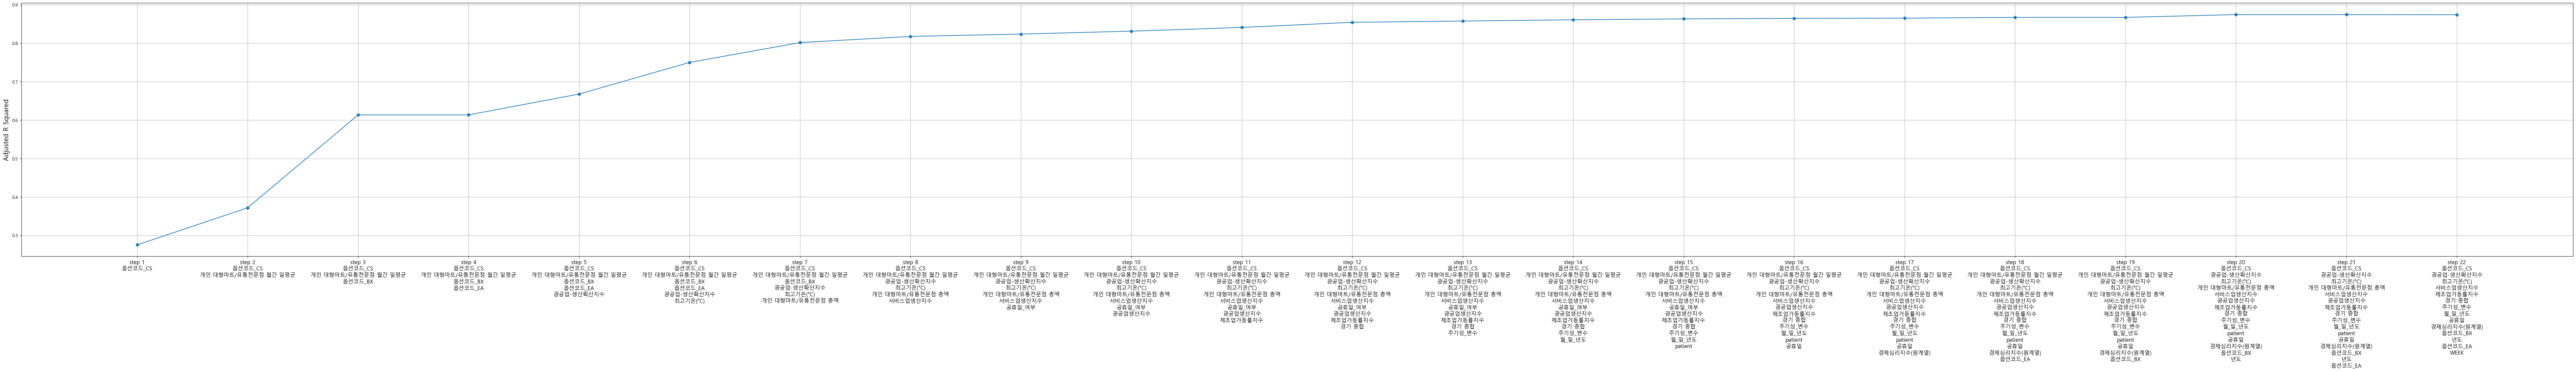

In [ ]:
import statsmodels.api as sm

X_train = sm.add_constant(x_train)
model = sm.OLS(y_train['판매수량'], X_train).fit()
# print(model.summary())

selected_variables = stepwise_feature_selection(X_train, y_train['판매수량'])

In [ ]:
model = sm.OLS(y_train['판매수량'], sm.add_constant(pd.DataFrame(x_train[selected_variables]))).fit(disp=0)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   판매수량   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     331.9
Date:                Mon, 04 Sep 2023   Prob (F-statistic):          1.99e-265
Time:                        15:20:59   Log-Likelihood:                -3827.1
No. Observations:                 620   AIC:                             7682.
Df Residuals:                     606   BIC:                             7744.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1381.8882     77.882     17.743      

In [ ]:
selected_variables

['옵션코드_CS',
 '광공업-생산확산지수',
 '최고기온(°C)',
 '서비스업생산지수',
 '제조업가동률지수',
 '경기 종합',
 '주기성_변수',
 '월_일_년도',
 '공휴일',
 '경제심리지수(원계열)',
 '옵션코드_BX',
 '년도',
 '옵션코드_EA',
 'WEEK']